In [1]:
import pandas as pd 
import numpy as np
from collections import  OrderedDict
from copy import deepcopy
from matplotlib import pyplot as plt

# LS + Btree

In [138]:
def gen_path(solver, solver_hyper, regularizer, depth_lst, 
            remove_ratio_lst = [0.05, 0.1, 0.2], 
            purpose='leastsquare_btree/details', 
            loss='ls', task='btree', lammax=1.0, lam_shrink=1e-2, 
            ):
    all_path = []
    for depth in depth_lst:
        dataset = f'ls_dep:{depth}_num:2x_sparse:0.1'
        for remove_ratio in remove_ratio_lst:
            path = f'../{purpose}/{solver}_{loss}_{regularizer}/{dataset}_lam_shrink:{lam_shrink}_{task}_{lammax}_{depth}_True_{remove_ratio}_{-1.0}'
            for k,v in solver_hyper.items():
                if k == 'ipg_strategy':
                    path += f'_{v}'
                else:
                    path += f'_{k}:{v}'
            path += '_stats.npy'
            all_path.append(path)
    return all_path

def create_hypers(solver, modify_dict={}):
    task_hypers_template = {
            'ProxGD':   OrderedDict({'proxgd_stepsize': 'linesearch'}),
            'ProxSAGA': OrderedDict({ 'ipg_strategy': 'linear_decay', 'seed':2023, 'proxsaga_lipcoef': 1.0,}),
            'ProxSVRG': OrderedDict({ 'ipg_strategy': 'linear_decay', 'seed':2023, 'proxsvrg_inner_repeat': 1, 'proxsvrg_lipcoef': 1.0}),
            'PStorm':   OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':2023,'pstorm_stepsize': 'diminishing', 'pstorm_betak': -1.0, 'pstorm_lipcoef': 1.0}),
            'RDA':      OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':2023, 'rda_stepconst': 1.0}),
            'SPStorm':  OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':2023, 'spstorm_betak': -1.0, 'spstorm_zeta': 'dynanmic', 'spstorm_lipcoef': 1.0})
        }
    hypers = task_hypers_template[solver]
    for k,v in modify_dict.items():
        hypers[k] = v
    return hypers
def load_from_npy(all_path, selected_keys=['xend', 'nnz', 'nz', 'Fend', 'iteration', 'status'], verbose=False):
    instance_dict = {}
    total_failed = 0
    for path in all_path:
        try:
            info = np.load(path, allow_pickle=True).item()
            depth, remove_ratio = path.split('True')[0].split("_")[-2], path.split('True')[1].split("_")[1]
            instance_name = f'{depth}_{remove_ratio}'
            instance_dict[instance_name] = {k:info[k] for k in selected_keys}
            # for k in ['total_bak_seq', 'inner_its_seq']:
            #     if k in selected_keys:
            #         instance_dict[instance_name][k] = np.sum(info[k])
            if info['status'] not in [0,1]:
                if verbose:
                    print(f'Warning: {instance_name} is not solved, status: {info["status"]}')
                total_failed += 1
        except FileNotFoundError:
            info = None
    return instance_dict, total_failed

def get_alg_df(ground_truth, 
               solver = 'ProxSVRG',
               ipg_strategy_lst = ['linear_decay', 'diminishing'],
               lipcoef_lst = [0.1, 0.5, 1.0],
               depth_lst = [11,12,13],
               list_of_metric = ['best_F_diff', 'last_nz_diff', 'first_id', 'first_cst_id', 'total_id'],
               max_epoch = 500):
    # collect raw results for solver
    dict_of_results = {}
    for ipg_strategy in ipg_strategy_lst:
        for lipcoef in lipcoef_lst:
            solver_hyper = create_hypers(solver)
            solver_hyper['ipg_strategy'] = ipg_strategy
            if solver != 'RDA':
                solver_hyper[f'{solver.lower()}_lipcoef'] = lipcoef
            else:
                solver_hyper[f'{solver.lower()}_stepconst'] = lipcoef
            solver_all_path = gen_path(solver, solver_hyper, regularizer='NatOG', depth_lst=depth_lst)
            solver_result, total_failed = load_from_npy(solver_all_path, selected_keys=['time', 'total_bak_seq', 'inner_its_seq', 'Fbest', 'status', 'nz_seq'])
            print(ipg_strategy, lipcoef, '--- [exit without code 0 or 1]:', total_failed)
            print("="*50)
            dict_of_results[f'{ipg_strategy}_{lipcoef}'] = (solver_result, total_failed)

    # construct the df for ground truth    
    df_dict = {'instance':[], 'ProxGD_best_F':[], 'ProxGD_nz':[]}
    for k, v in ground_truth.items():
        df_dict['instance'].append(k)
        df_dict['ProxGD_best_F'].append(v['Fend'])
        df_dict['ProxGD_nz'].append(v['nz'])   
    
    # construct the df for solver
    for hyper_combine, solver_result in dict_of_results.items():
        for metric in list_of_metric:
            df_dict[f"{solver}_{hyper_combine}_{metric}"] = []
        for instance_name, instance_info in solver_result[0].items():
            nz_gt = ground_truth[instance_name]['nz']
            F_gt = ground_truth[instance_name]['Fend']
            nz_seq = instance_info['nz_seq']
            if solver == "ProxSVRG":
                # count as data pass
                nz_seq = nz_seq[:max_epoch+1]
            # handel identification metrics
            temp = np.where(np.array(nz_seq) == nz_gt)[0]
            total_identification = len(temp)
            if total_identification > 0:
                first_identification = temp[0]
                first_consistent_identification = np.nan
                for i in range(len(nz_seq)-1, -1, -1):
                    if np.array(nz_seq[i]) != nz_gt:
                        # the previous one is the first id
                        first_consistent_identification = i + 1
                        break
                if first_consistent_identification == 0 or first_consistent_identification == (max_epoch+1):
                    first_consistent_identification = np.nan
            else:
                first_identification = first_consistent_identification = total_identification = np.nan        
            df_dict[f"{solver}_{hyper_combine}_best_F_diff"].append(np.abs(instance_info['Fbest']-F_gt))
            df_dict[f"{solver}_{hyper_combine}_last_nz_diff"].append(np.abs(nz_seq[-1]-nz_gt))            
            df_dict[f"{solver}_{hyper_combine}_first_id"].append(first_identification)   
            df_dict[f"{solver}_{hyper_combine}_first_cst_id"].append(first_consistent_identification)
            df_dict[f"{solver}_{hyper_combine}_total_id"].append(total_identification)
        
    return pd.DataFrame.from_dict(df_dict)

def metric_plot(dict_of_results, ground_truth, instance_id = '11_0.05', 
                ipg_strategy_lst=['linear_decay', 'diminishing'], lipcoef_lst = [1.0]):
    x_gt = ground_truth[instance_id]['xend']
    F_gt = ground_truth[instance_id]['Fend']
    nz_gt = ground_truth[instance_id]['nz']

    fig, axs = plt.subplots(2, 2, figsize=(18, 8))
    for ipg_strategy in ipg_strategy_lst:
        x_seq = dict_of_results[f'{ipg_strategy}_1.0'][0][instance_id]['x_seq']
        F_seq = dict_of_results[f'{ipg_strategy}_1.0'][0][instance_id]['F_seq']
        nz_seq = dict_of_results[f'{ipg_strategy}_1.0'][0][instance_id]['nz_seq']
        inner_its_seq = dict_of_results[f'{ipg_strategy}_1.0'][0][instance_id]['inner_its_seq']
        total_bak_seq = dict_of_results[f'{ipg_strategy}_1.0'][0][instance_id]['total_bak_seq']
        matrix_vec_prod_seq = np.array(inner_its_seq) + (np.array(total_bak_seq) + 1.0)
        if solver == 'ProxSVRG':
            # take odd elements
            x_seq = x_seq[0::2]
            F_seq = F_seq[0::2]
            nz_seq = nz_seq[0::2]
        x_distance_lst = []
        F_distance_lst = []
        for i in range(len(x_seq)):
            diff = (x_seq[i] - x_gt).toarray()
            x_distance_lst.append(np.sum(diff * diff))
            F_distance_lst.append(np.abs(F_seq[i] - F_gt))        
        axs[0][0].semilogy(x_distance_lst, label=f'{ipg_strategy}')
        axs[0][1].semilogy(F_distance_lst, label=f'{ipg_strategy}')
        axs[1][0].plot(nz_seq[:100], label=f'{ipg_strategy}')
        axs[1][0].axhline(nz_gt, color='black', linewidth=2, alpha=0.2) 
        # axs[1][1].bar(range(len(matrix_vec_prod_seq)), matrix_vec_prod_seq, label=f'{ipg_strategy}')
        axs[1][1].plot(matrix_vec_prod_seq[:100], label=f'{ipg_strategy}')    
    axs[0][0].legend()
    axs[0][1].legend()
    axs[1][0].legend()
    axs[1][1].legend()
    fontsize = 12
    for i in range(2):
        for j in range(2):
            axs[i][j].set_xlabel('number of data pass', fontsize=fontsize)
            axs[i][j].tick_params(axis='both', which='major', labelsize=fontsize)
            axs[i][j].legend(fancybox=True, prop={'size': fontsize})
    axs[0][0].set_ylabel(r'$\|x_k-x^*\|^2$', fontsize=fontsize)
    axs[0][1].set_ylabel(r'$F_k-F^*$', fontsize=fontsize)
    axs[1][0].set_ylabel('number of zero groups', fontsize=fontsize)
    axs[1][1].set_ylabel('Dual objective Evaluation', fontsize=fontsize)
    fig.suptitle(f'{instance_id}', y=0.93, fontsize=fontsize)

In [122]:
solver = 'ProxGD'
solver_hyper = create_hypers(solver)
all_path = gen_path(solver, solver_hyper, regularizer='TreeOG', depth_lst=[11,12,13,14])
ground_truth, total_failed = load_from_npy(all_path)

## ProxSVRG

In [135]:
solver = 'ProxSVRG'
ipg_strategy_lst = ['linear_decay', 'diminishing']
lipcoef_lst = [1.0]
dict_of_results = {}
for ipg_strategy in ipg_strategy_lst:
    for lipcoef in lipcoef_lst:
        solver_hyper = create_hypers(solver)
        solver_hyper['ipg_strategy'] = ipg_strategy
        solver_hyper[f'{solver.lower()}_lipcoef'] = lipcoef
        solver_all_path = gen_path(solver, solver_hyper, regularizer='NatOG', depth_lst=[11,12,13,14])
        solver_result, total_failed = load_from_npy(solver_all_path, selected_keys=['time', 'total_bak_seq', 'inner_its_seq', 'Fbest', 'status', 'nz_seq', 'x_seq', 'F_seq'])
        print(ipg_strategy, lipcoef, '--- [exit without code 0 or 1]:', total_failed)
        print("="*50)
        dict_of_results[f'{ipg_strategy}_{lipcoef}'] = (solver_result, total_failed)

linear_decay 1.0 --- [exit without code 0 or 1]: 3
diminishing 1.0 --- [exit without code 0 or 1]: 0


In [139]:
# dict_of_results['linear_decay_1.0'][0].keys()
solver_result.keys()

dict_keys(['11_0.05', '11_0.1', '11_0.2', '12_0.05', '12_0.1', '12_0.2', '13_0.05', '13_0.1', '13_0.2', '14_0.05', '14_0.1', '14_0.2'])

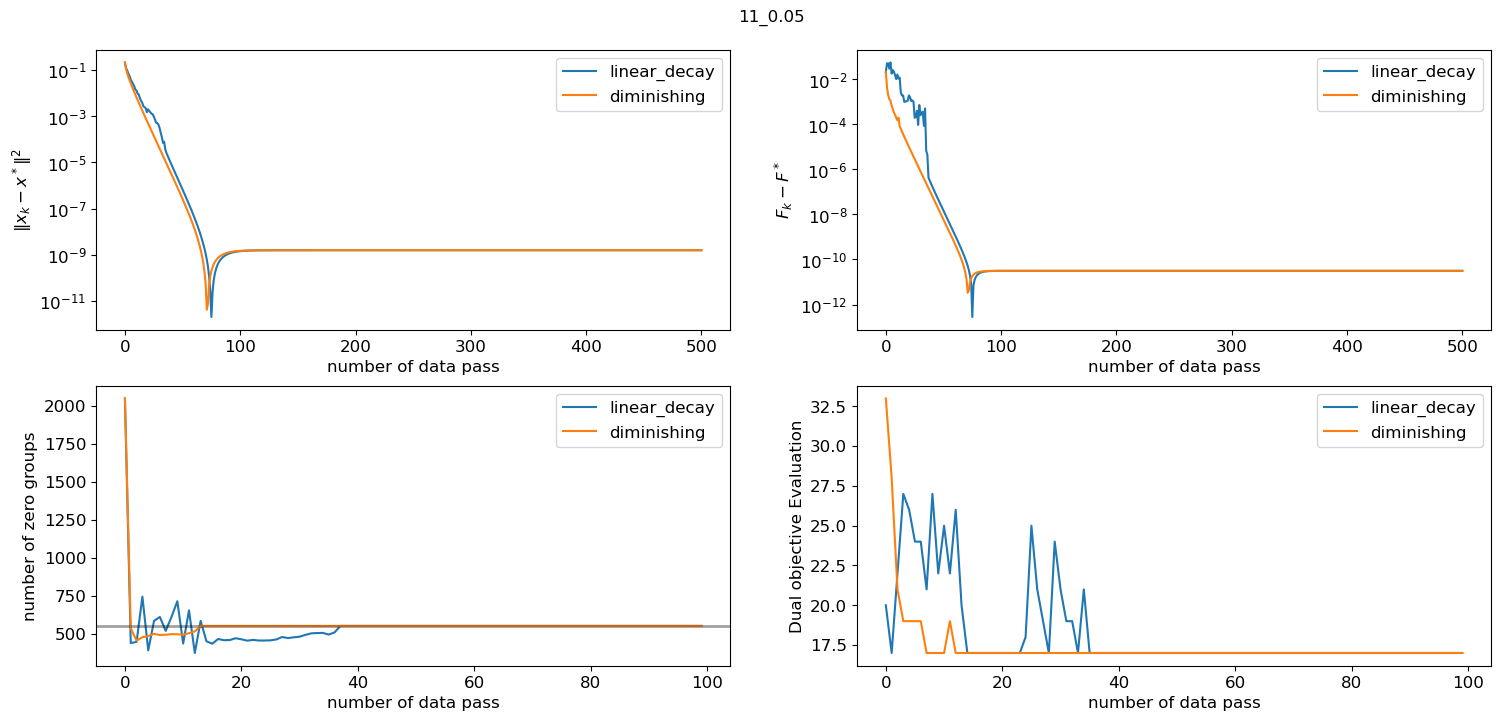

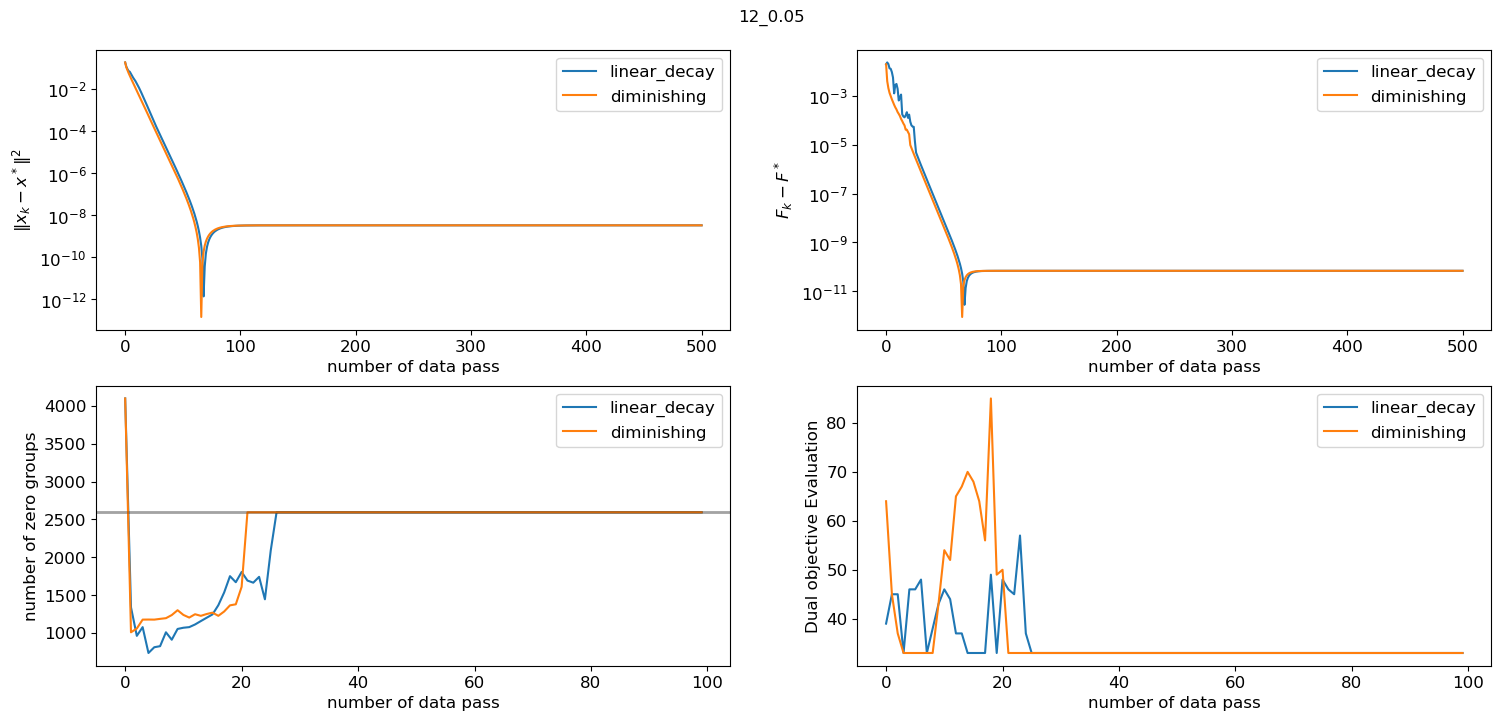

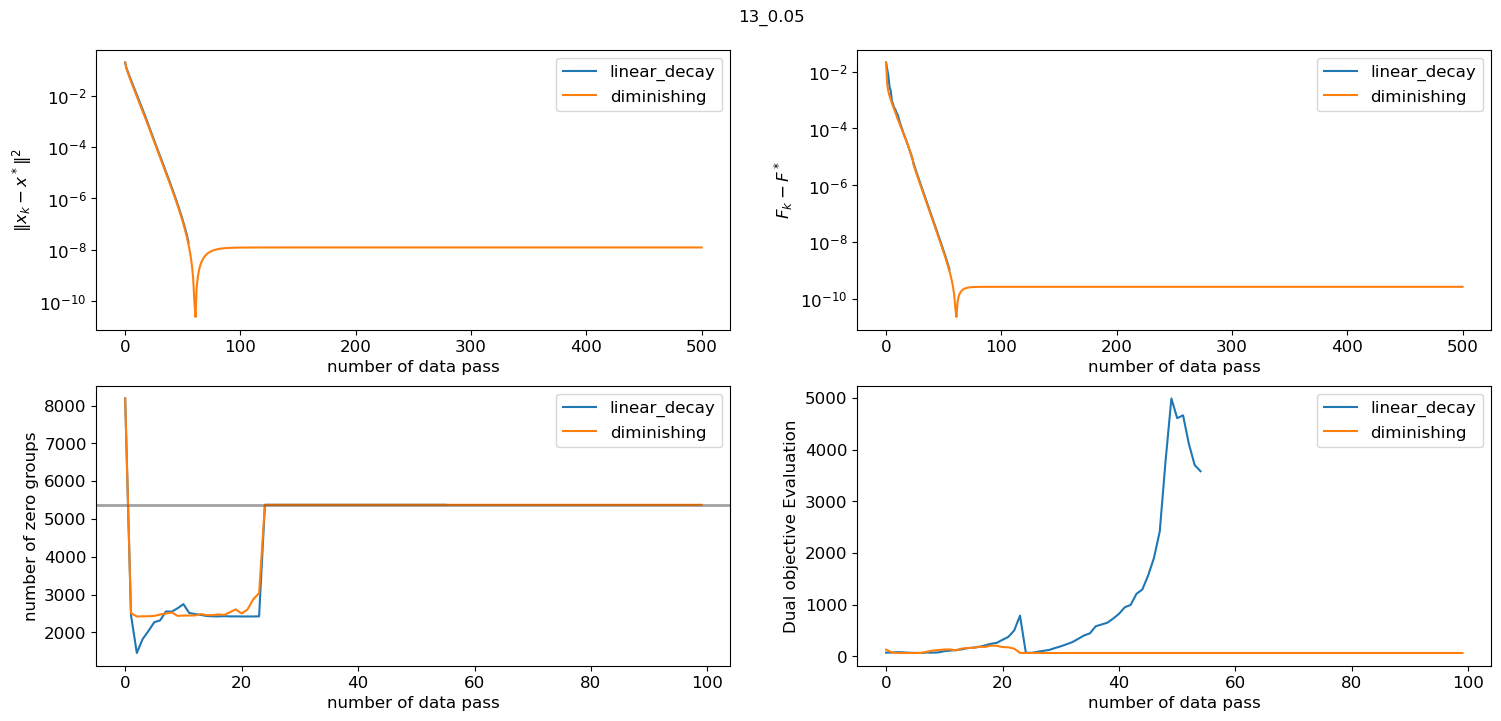

In [141]:
metric_plot(dict_of_results, ground_truth, instance_id = '11_0.05')
metric_plot(dict_of_results, ground_truth, instance_id = '12_0.05')
metric_plot(dict_of_results, ground_truth, instance_id = '13_0.05')
# metric_plot(dict_of_results, ground_truth, instance_id = '14_0.05')

# ProxSAGA

In [117]:
solver = 'ProxSAGA'
ipg_strategy_lst = ['linear_decay', 'diminishing']
lipcoef_lst = [1.0]
dict_of_results = {}
for ipg_strategy in ipg_strategy_lst:
    for lipcoef in lipcoef_lst:
        solver_hyper = create_hypers(solver)
        solver_hyper['ipg_strategy'] = ipg_strategy
        solver_hyper[f'{solver.lower()}_lipcoef'] = lipcoef
        solver_all_path = gen_path(solver, solver_hyper, regularizer='NatOG', depth_lst=[11,12,13])
        solver_result, total_failed = load_from_npy(solver_all_path, selected_keys=['time', 'total_bak_seq', 'inner_its_seq', 'Fbest', 'status', 'nz_seq', 'x_seq', 'F_seq'])
        print(ipg_strategy, lipcoef, '--- [exit without code 0 or 1]:', total_failed)
        print("="*50)
        dict_of_results[f'{ipg_strategy}_{lipcoef}'] = (solver_result, total_failed)

linear_decay 1.0 --- [exit without code 0 or 1]: 3
diminishing 1.0 --- [exit without code 0 or 1]: 0


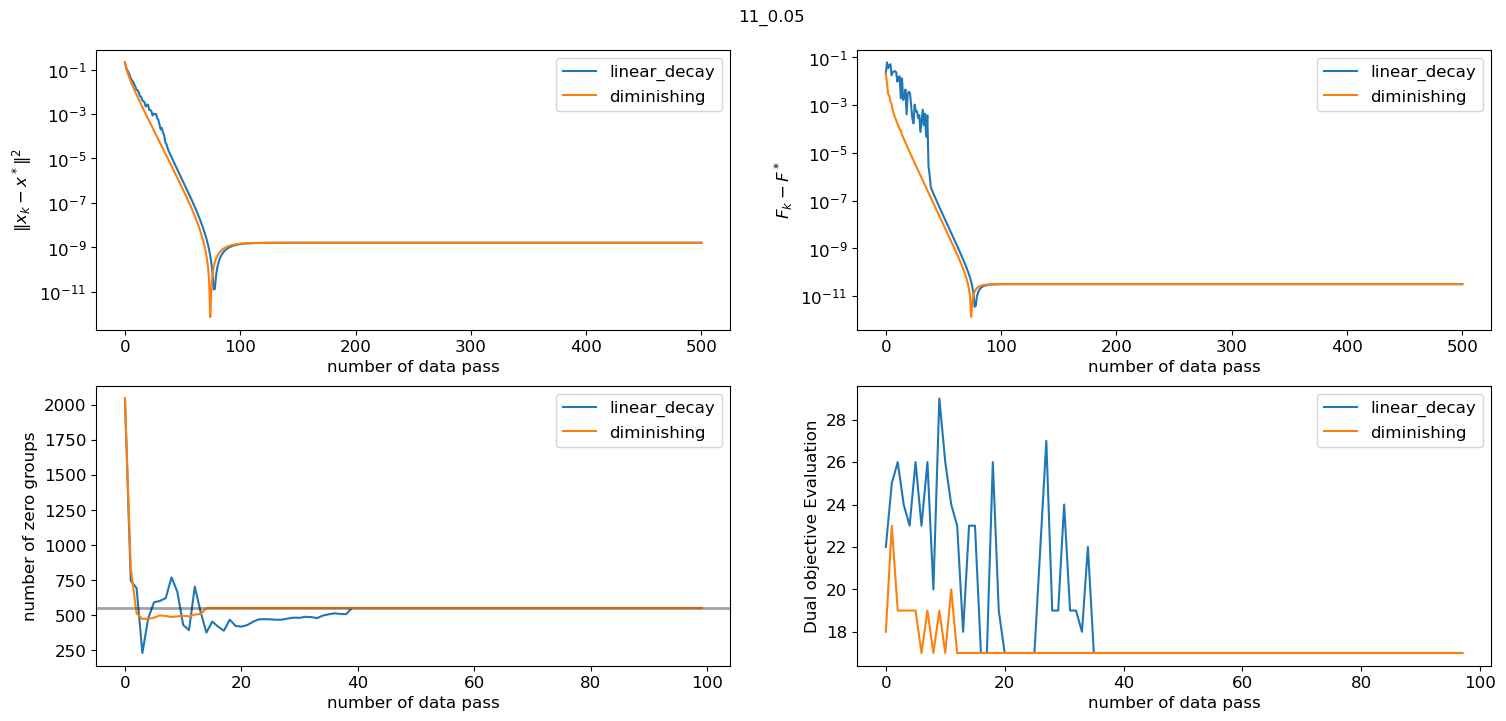

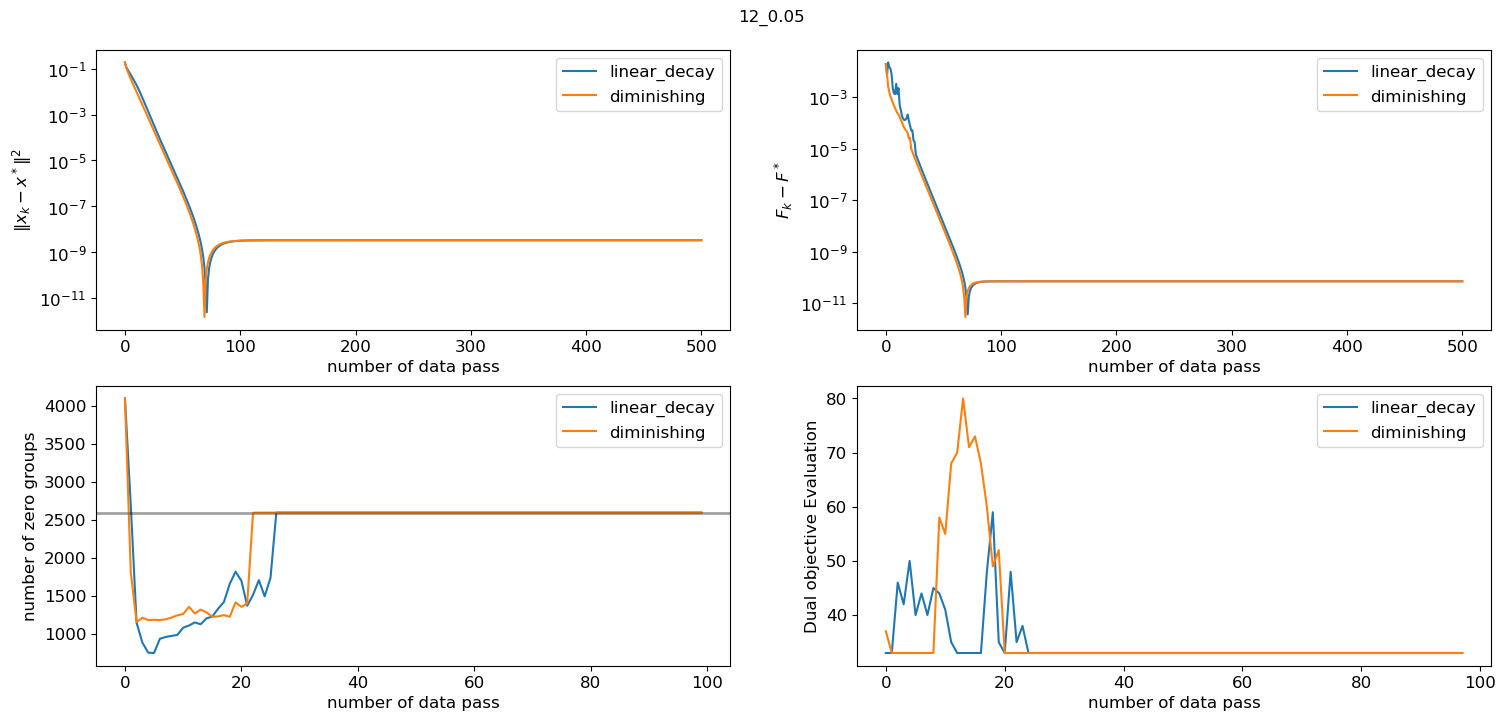

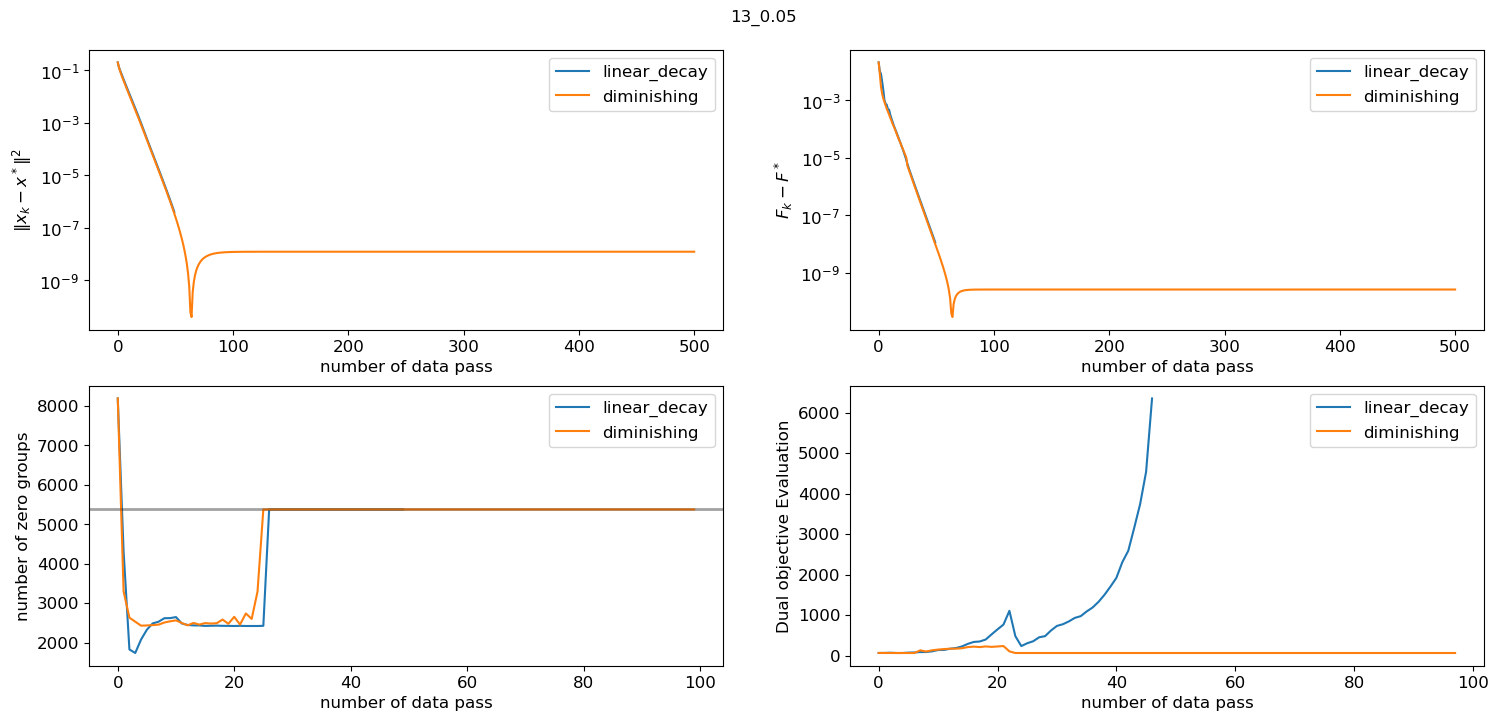

In [118]:
metric_plot(dict_of_results, ground_truth, instance_id = '11_0.05')
metric_plot(dict_of_results, ground_truth, instance_id = '12_0.05')
metric_plot(dict_of_results, ground_truth, instance_id = '13_0.05')

# SPTSORM

In [119]:
solver = 'SPStorm'
ipg_strategy_lst = ['diminishing']
lipcoef_lst = [1.0]
dict_of_results = {}
for ipg_strategy in ipg_strategy_lst:
    for lipcoef in lipcoef_lst:
        solver_hyper = create_hypers(solver)
        solver_hyper['ipg_strategy'] = ipg_strategy
        solver_hyper[f'{solver.lower()}_lipcoef'] = lipcoef
        solver_all_path = gen_path(solver, solver_hyper, regularizer='NatOG', depth_lst=[11,12,13])
        solver_result, total_failed = load_from_npy(solver_all_path, selected_keys=['time', 'total_bak_seq', 'inner_its_seq', 'Fbest', 'status', 'nz_seq', 'x_seq', 'F_seq'])
        print(ipg_strategy, lipcoef, '--- [exit without code 0 or 1]:', total_failed)
        print("="*50)
        dict_of_results[f'{ipg_strategy}_{lipcoef}'] = (solver_result, total_failed)

diminishing 1.0 --- [exit without code 0 or 1]: 0


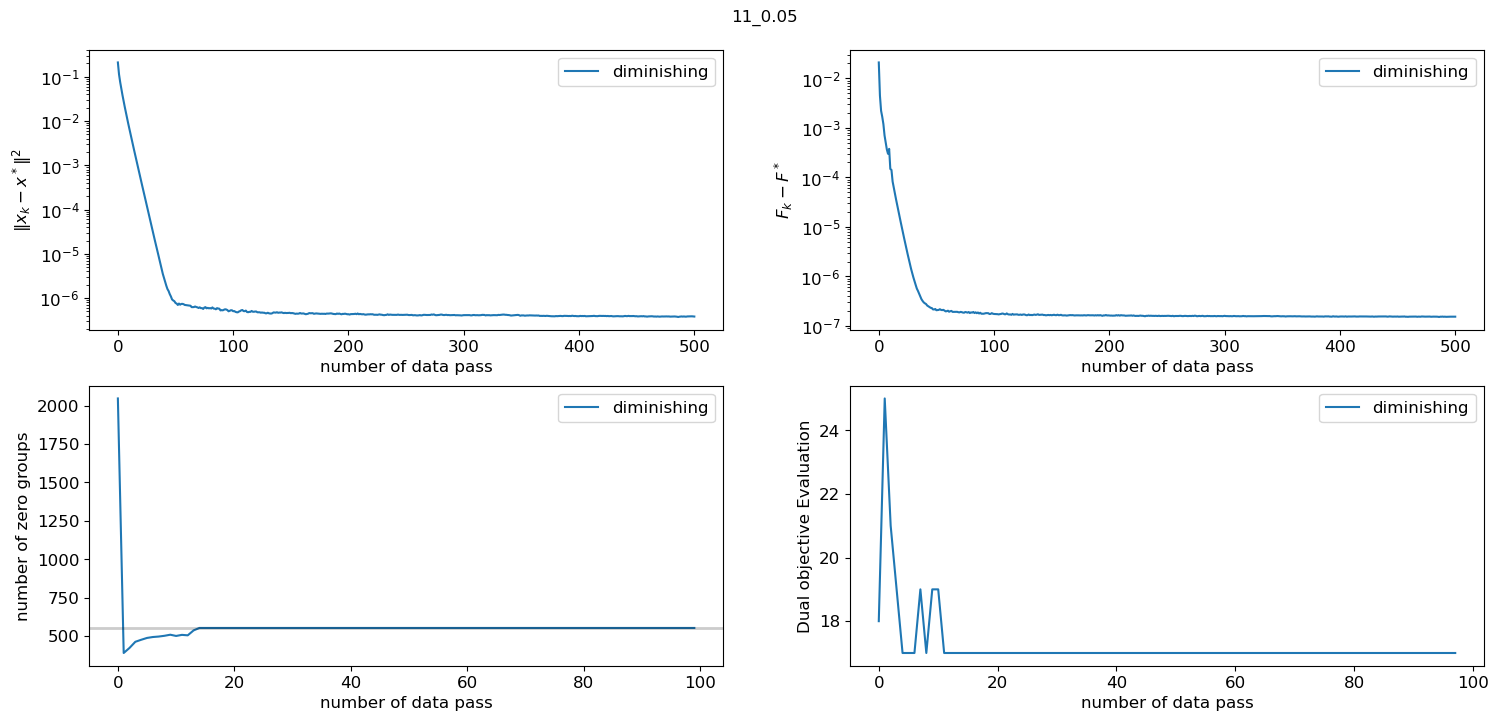

In [120]:
metric_plot(dict_of_results, ground_truth, instance_id = '11_0.05', ipg_strategy_lst = ['diminishing'])